<a href="https://colab.research.google.com/github/Rachhh53/Digit-Recognizer/blob/main/DigitRecognizerNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ingest

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from collections import Counter
import time

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, LSTM
from keras import backend as K

In [2]:
!wget https://github.com/Rachhh53/Digit-Recognizer/archive/refs/heads/main.zip

--2022-02-20 00:01:13--  https://github.com/Rachhh53/Digit-Recognizer/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Rachhh53/Digit-Recognizer/zip/refs/heads/main [following]
--2022-02-20 00:01:13--  https://codeload.github.com/Rachhh53/Digit-Recognizer/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [   <=>              ]  16.33M  23.7MB/s    in 0.7s    

2022-02-20 00:01:14 (23.7 MB/s) - ‘main.zip’ saved [17120284]



In [3]:
!unzip "/content/main.zip" -d "/content/output_folder/"

Archive:  /content/main.zip
7317a19b02285652ab86b67d769167089ddb9525
   creating: /content/output_folder/Digit-Recognizer-main/
  inflating: /content/output_folder/Digit-Recognizer-main/DigitRecognizer.ipynb  
 extracting: /content/output_folder/Digit-Recognizer-main/README.md  
 extracting: /content/output_folder/Digit-Recognizer-main/test.csv.zip  
 extracting: /content/output_folder/Digit-Recognizer-main/train.csv.zip  


In [4]:
!unzip "/content/output_folder/Digit-Recognizer-main/test.csv.zip" -d "/content/output_folder/Digit-Recognizer-main/csvs"

Archive:  /content/output_folder/Digit-Recognizer-main/test.csv.zip
  inflating: /content/output_folder/Digit-Recognizer-main/csvs/test.csv  


In [5]:
!unzip "/content/output_folder/Digit-Recognizer-main/train.csv.zip" -d "/content/output_folder/Digit-Recognizer-main/csvs"

Archive:  /content/output_folder/Digit-Recognizer-main/train.csv.zip
  inflating: /content/output_folder/Digit-Recognizer-main/csvs/train.csv  


In [6]:
df_test = pd.read_csv('/content/output_folder/Digit-Recognizer-main/csvs/test.csv')

In [7]:
df_train = pd.read_csv('/content/output_folder/Digit-Recognizer-main/csvs/train.csv')

In [8]:
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# EDA

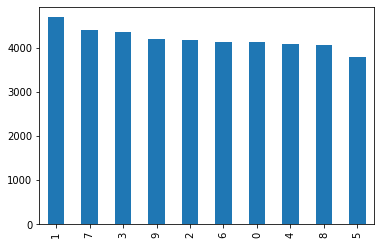

In [10]:
# Training data insights
df_train['label'].value_counts().plot.bar()

Class 1 has the most observations

In [11]:
y = df_train['label']
X = df_train.drop(['label'], axis=1)

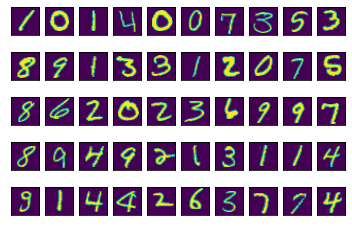

In [12]:
def show_images(num_images):
    if num_images % 10 == 0 and num_images <= 100:
        for digit_num in range(0,num_images): 
            plt.subplot(num_images/10,10,digit_num+1) #create subplots
            mat_data = X.iloc[digit_num].values.reshape(28,28)  #reshape images
            plt.imshow(mat_data) #plot the data
            plt.xticks([]) #removes numbered labels on x-axis
            plt.yticks([]) #removes numbered labels on y-axis
show_images(50)

In [13]:
y.shape

(42000,)

In [14]:
X.shape

(42000, 784)

In [15]:
X = X/255
df_test = df_test/255

In [16]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.20)

# Model

In [17]:
x_train = x_train.values.reshape(x_train.shape[0], 28,28,1)
x_valid = x_valid.values.reshape(x_valid.shape[0], 28,28,1)
df_test = df_test.values.reshape(df_test.shape[0], 28,28,1)



In order to use keras, every image needs to be represented as a 28x28 array instead of a 1D array of size 784. We need to do this for all x values for train and test.


In [18]:
x_train.shape

(33600, 28, 28, 1)

In [19]:
df_test.shape

(28000, 28, 28, 1)

In [20]:
x_valid.shape

(8400, 28, 28, 1)

Set up for some visualizations<br>
https://towardsdatascience.com/deep-learning-with-python-neural-networks-complete-tutorial-6b53c0b06af0

In [21]:
'''
Extract info for each layer in a keras model.
'''
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential doesn't show the input layer
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0, 
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers



'''
Plot the structure of a keras neural network.
'''
def visualize_nn(model, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]
    
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color
        
        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        
        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/4.0, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], 
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space], 
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()

In [22]:
def get_metrics(model, x, y):
  model.summary()
  #print(keras.utils.plot_model(model, show_shapes=True))
  start_time = time.time()
  model.compile(loss='sparse_categorical_crossentropy', # index from 0-9 in our labels
              optimizer='sgd', # stocastic gradient descent
              metrics=['acc'])
  history = model.fit(x, y, epochs=10, validation_split=0.1)
  end_time = time.time()
  total_time = (end_time - start_time)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.grid(True)
  plt.gca().set_ylim(0,1)
  plt.show()
  summary = {'Run Time': round(total_time, 3), 'Training Accuracy': round(history.history['acc'][-1], 3), 
             'Validation Accuracy': round(history.history['val_acc'][-1], 3)}
  return summary

## Sequential

Begin with the simplest model as a baseline.

https://towardsdatascience.com/deep-learning-with-python-neural-networks-complete-tutorial-6b53c0b06af0

In [23]:
# super simple
model = Sequential(name="Perceptron", layers=[
                  keras.layers.Dense( #a fully connected layer
                  name="dense",
                  input_dim=3,        #with 3 features as the input
                  units=1,            #and 1 node because we want 1 output
                  activation='linear' #f(x)=x
    )
])
model.summary()

Model: "Perceptron"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


Shows us the structure and size in terms of parameters to train. We have 4 parameters and they are all trainable.

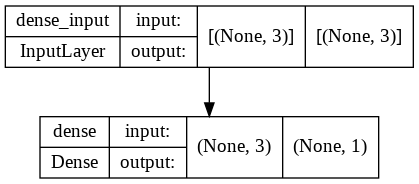

In [24]:
keras.utils.plot_model(model, show_shapes=True)

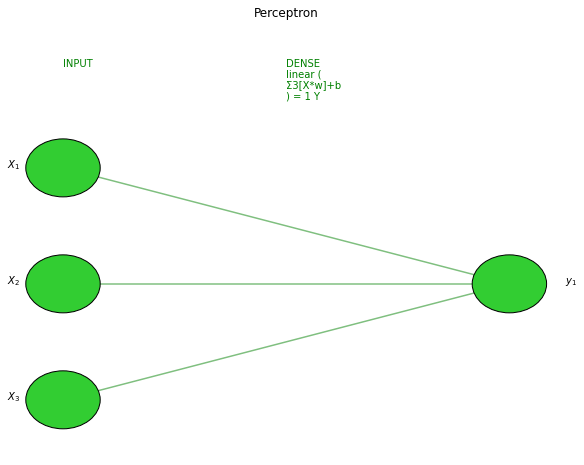

In [25]:
visualize_nn(model, description=True, figsize=(10,8))

### Activation Layer

ReLU - a piecewise linear function that returns the output only if it’s positive, and it is mainly used for hidden layers.

In [26]:
model2 = Sequential([keras.layers.Flatten(input_shape=[28,28]), # convert eachs image into 1D array
                    keras.layers.Dense(300, activation='relu'),  # each dense layer manages its own weight and is fully connected
                    keras.layers.Dense(100, activation='relu'), # ReLU acivation function to perform piecewise lienar function
                    keras.layers.Dense(10, activation='softmax')])

Summary states all parameters are trainable

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
945/945 [==============================] - 6s 5ms/step - loss: 0.7796 - acc: 0.8036 - val_loss: 0.4012 - val_acc: 0.8935
Epoch 2/10
945/945 [==============================

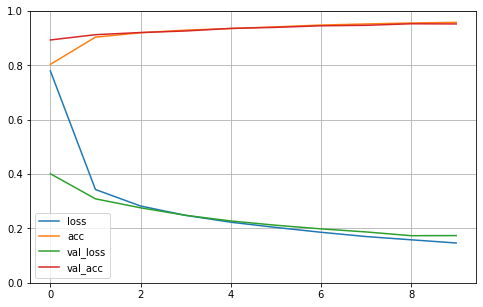

In [27]:
summary2 = get_metrics(model2, x_train, y_train)

Both training and validaton accuracy increased as we iterated over epochs. Since the orange and red curves do not overlap, which means we are not overfitting.<br>
The blue and green curves show that both the error during both training and validation decreased over the epochs.

In [28]:
model2.evaluate(x_valid, y_valid)

263/263 [==============================] - 1s 3ms/step - loss: 0.1699 - acc: 0.9508


[0.1699243187904358, 0.9508333206176758]

In [29]:
preds = model2.predict(x_valid)
print('shape of prediction:', preds.shape)

shape of prediction: (8400, 10)


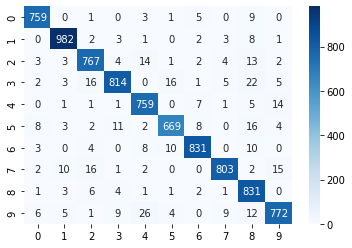

In [30]:
def cm_matrix(model, x_v, y_v):
  pred = model.predict(x_v)
  pred_classes = np.argmax(pred, axis=1)
  labels = [0,1,2,3,4,5,6,7,8,9]
  cm = confusion_matrix(y_v, pred_classes)
  sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
cm_matrix(model2, x_valid, y_valid)

### Batch Normalization

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_3 (Dense)             (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)             

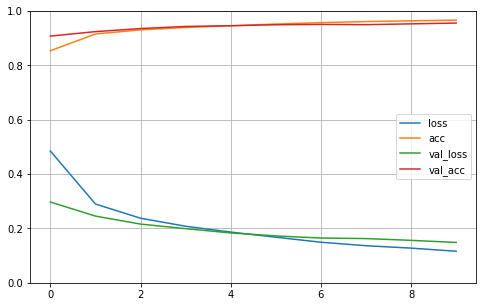

In [31]:
model3 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])
summary3 = get_metrics(model3, x_train, y_train)

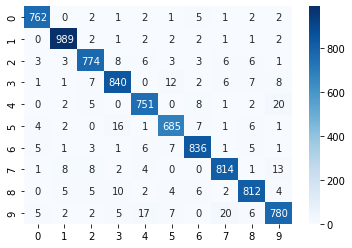

In [32]:
cm_matrix(model3, x_valid, y_valid)

## DNN

In [33]:
def sample_prediction(index, model):
    plt.imshow(df_test[index].reshape(28, 28),cmap='Greys')
    pred = model.predict(df_test[index].reshape(1, 28, 28, 1))
    print(np.argmax(pred))

In [34]:
def simple_DNN():
    start_time = time.time()
    model = Sequential()
    model.add(Flatten())  # input layer
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dense(10, activation = 'softmax'))
    model.compile(optimizer= "adam", 
                  loss= "sparse_categorical_crossentropy", 
                  metrics=["acc"])
    history = model.fit(x_train, y_train, epochs=10, validation_split=0.1)
    end_time = time.time()
    total_time = end_time - start_time
    model.summary()
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
    summary = {'Total Time': round(total_time, 3), 'Training Accuracy': round(history.history['acc'][-1], 3), 
             'Validation Accuracy': round(history.history['val_acc'][-1], 3)}
    return model, summary

Epoch 1/10
945/945 [==============================] - 4s 3ms/step - loss: 0.3144 - acc: 0.9075 - val_loss: 0.1733 - val_acc: 0.9485
Epoch 2/10
945/945 [==============================] - 3s 3ms/step - loss: 0.1274 - acc: 0.9617 - val_loss: 0.1271 - val_acc: 0.9616
Epoch 3/10
945/945 [==============================] - 3s 3ms/step - loss: 0.0854 - acc: 0.9734 - val_loss: 0.1157 - val_acc: 0.9643
Epoch 4/10
945/945 [==============================] - 3s 3ms/step - loss: 0.0611 - acc: 0.9804 - val_loss: 0.1135 - val_acc: 0.9690
Epoch 5/10
945/945 [==============================] - 3s 3ms/step - loss: 0.0473 - acc: 0.9848 - val_loss: 0.1132 - val_acc: 0.9679
Epoch 6/10
945/945 [==============================] - 3s 3ms/step - loss: 0.0360 - acc: 0.9886 - val_loss: 0.1257 - val_acc: 0.9652
Epoch 7/10
945/945 [==============================] - 3s 3ms/step - loss: 0.0301 - acc: 0.9890 - val_loss: 0.1468 - val_acc: 0.9667
Epoch 8/10
945/945 [==============================] - 3s 3ms/step - loss: 0.

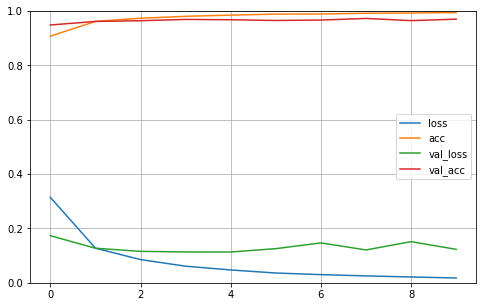



Model Training



Model Evaluation

263/263 [==============================] - 1s 2ms/step - loss: 0.1199 - acc: 0.9712


Sample Prediction
2


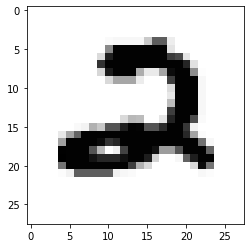

In [35]:
DNNmodel, summary4 = simple_DNN()
print("\n\nModel Training\n")
print("\n\nModel Evaluation\n")
DNNmodel.evaluate(x_valid, y_valid)
print("\n\nSample Prediction")
sample_prediction(0, DNNmodel)

In [36]:
DNNpreds = DNNmodel.predict(x_valid)
print('shape of prediction:', DNNpreds.shape)

shape of prediction: (8400, 10)


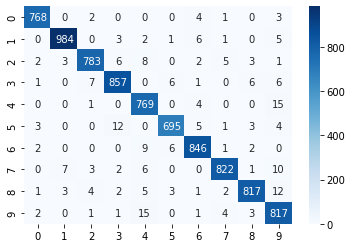

In [37]:
cm_matrix(DNNmodel, x_valid, y_valid)

### With Dropout

In [38]:
# define metrics
def Recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def Precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def R2(y, y_hat):
    ss_res =  K.sum(K.square(y - y_hat)) 
    ss_tot = K.sum(K.square(y - K.mean(y))) 
    return ( 1 - ss_res/(ss_tot + K.epsilon()) )

In [48]:
def DNN_w_drop(n_features):
    start_time = time.time()
    model = Sequential(name="DeepNNDropout")
    model.add(Flatten(input_shape=[28,28]))  # input layer
    # first hidden layer
    model.add(Dense(name="h1", input_dim=n_features,
                 units=int(round((n_features+1)/2)), 
                 activation='relu'),)
    model.add(Dropout(name="drop1", rate=.2))
    # second hidden layer
    model.add(Dense(name="h2",
                 units=int(round((n_features+1)/4)), 
                 activation='relu'),)
    model.add(Dropout(name="drop2", rate=.2))
    model.add(Dense(name="output", units=1, activation='sigmoid')) # output layer

    model.compile(optimizer= "adam", 
                  loss= "mean_absolute_error", 
                  metrics=["acc"])
    history = model.fit(x_train, y_train, epochs=5, validation_split=0.1)
    end_time = time.time()
    total_time = end_time - start_time
    model.summary()
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    summary = {'Total Time': round(total_time, 3), 'Training Accuracy': round(history.history['acc'][-1], 3), 
             'Validation Accuracy': round(history.history['val_acc'][-1], 3)}
    return model, summary

Epoch 1/5
945/945 [==============================] - 3s 2ms/step - loss: 3.6657 - acc: 0.1542 - val_loss: 3.5609 - val_acc: 0.1952
Epoch 2/5
945/945 [==============================] - 2s 2ms/step - loss: 3.6177 - acc: 0.1679 - val_loss: 3.5540 - val_acc: 0.2039
Epoch 3/5
945/945 [==============================] - 2s 2ms/step - loss: 3.6062 - acc: 0.1697 - val_loss: 3.5542 - val_acc: 0.2003
Epoch 4/5
945/945 [==============================] - 2s 2ms/step - loss: 3.6004 - acc: 0.1691 - val_loss: 3.5547 - val_acc: 0.1982
Epoch 5/5
945/945 [==============================] - 2s 2ms/step - loss: 3.5969 - acc: 0.1715 - val_loss: 3.5541 - val_acc: 0.1988
Model: "DeepNNDropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 h1 (Dense)                  (None, 6)                 471

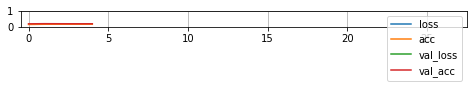

In [49]:
n_features = 10

DNNmodel_dropout, summary5 = DNN_w_drop(n_features)
print("\n\nModel Training\n")
print("\n\nModel Evaluation\n")
DNNmodel_dropout.evaluate(x_valid, y_valid)
print("\n\nSample Prediction")
sample_prediction(0, DNNmodel_dropout)

In [41]:
DNNpreds_dropout = DNNmodel_dropout.predict(x_valid)
print('shape of prediction:', DNNpreds.shape)

shape of prediction: (8400, 10)


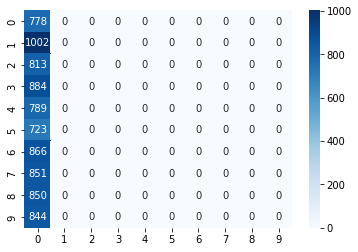

In [42]:
cm_matrix(DNNmodel_dropout, x_valid, y_valid)

# Conclusion